In [1]:
%load_ext lab_black
%load_ext autotime
import numpy as np

time: 134 ms (started: 2022-12-25 14:49:51 -08:00)


# SMMDS

A stochastic metric multi-dimensional scaling algorithm. Metric MDS is the version of MDS which tries to directly reproduce input distances in the output distances (i.e. no rescaling allowed). Effectively this is about reducing the stress:

$$
\mathrm{STRESS} = \sum_{i<j} (r_{ij} - d_{ij})^2
$$

where $r_{ij}$ is the input distance between item $i$ and $j$ and $d_{ij}$ is the equivalent output distance. The sum is over all pairs $\left(i, j\right)$ so this doesn't scale very well.

This package implements a stochastic version of MMDS by the simple expedient of not sampling all pairs. Instead you set `n_samples`: for each item in the dataset, its distance to `n_samples` other items chosen randomly is measured and only those pairs are used to define the gradient. Some form of optimization which can be used with noisy stochastic gradients is then used to refine the coordinates. The default is to use [Adam](https://arxiv.org/abs/1412.6980).

This approach is inspired by [Stochastic Proximity Embedding](https://doi.org/10.1073/pnas.242424399) (SPE) and [SQuadMDS](https://arxiv.org/abs/2202.12087). The [SQuadMDS github repo](https://github.com/PierreLambert3/SQuaD-MDS-and-FItSNE-hybrid) does not have a package available or even a license, so I can't use it directly in drnb.

## Note

This notebook assumes you have run the `tasic2018` and `airfoil` notebooks in the `notebooks/data-pipeline` folder.

In [2]:
import drnb.embed.pipeline as pl

time: 6.8 s (started: 2022-12-25 14:49:51 -08:00)


In the example below (the Z-scaled [airfoil](https://archive.ics.uci.edu/ml/datasets/airfoil+self-noise) dataset as used in the SQuadMDS paper) I have added two extra evaluation metrics: 

* `"exact-stress"`: this calculates the stress for all pairs of items in the data although it reports the value as the square root of the mean, so it's effectively the RMS of the disparity in distances. You should most definitely *not* use it for large or high-dimensional datasets. As a result, I have given this a slightly difficult-to-remember name so you can't accidentally ask for it.
* `"astress"`: an approximate version of the stress (with the same root-mean scaling), using the same stochastic sampling as used by the SMMDS method. This uses 3 random samples per item by default. I also provide a version using `n_samples=10` (mainly so I don't forget how to add parameters to the evaluation metric myself).

[14:50:11] INFO     Loading faiss with AVX2 support.                                                   ]8;id=723752;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=166011;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=996773;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=420000;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=699759;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=463010;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=26465;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=158727;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

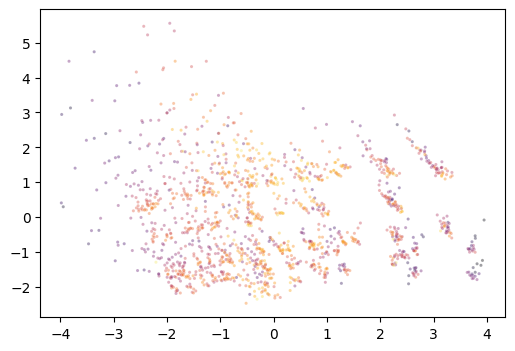

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.8714570858283435, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.9160777140104133, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.5039698381015747, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.5013173652694611, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.612401862940785, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='Stress', label='stress-euclidean', value=17.001107303985297, info={'metric': 'euclidean'}),
 EvalResult(eval_type='ApproxStress', label='astress-euclidean-3', value=1.0565725957505943, info={'metric': 'euclidean', 'n_samples': 3}),
 EvalResult(eval_type='ApproxStress', label='astress-euclidean-10', value=1.9672325061

time: 16.1 s (started: 2022-12-25 14:49:58 -08:00)


In [3]:
pl.standard_eval(
    method="smmds",
    params=dict(learning_rate=0.01, n_epochs=5000),
    dataset="airfoil",
    extra_eval=["exact-stress", "astress", ("astress", dict(n_samples=10))],
    extra_plot=dict(palette="inferno", cex=5),
)

And here's the PCA result (which SMMDS initialized from by default), just to prove that:

* SMMDS does something
* The something it does actually reduces the exact stress
* And the approximate stress is also reduced

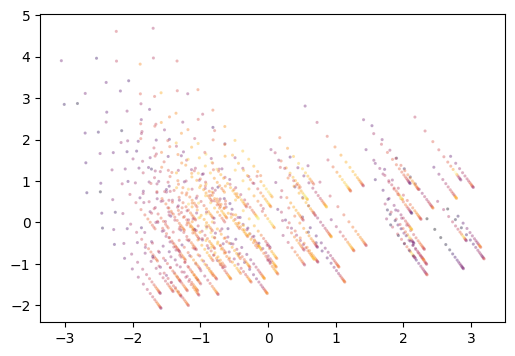

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.8530938123752494, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.8842370623596197, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.37285429141716575, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.4141450432468397, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.5576668884453315, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='Stress', label='stress-euclidean', value=24.95919386015259, info={'metric': 'euclidean'}),
 EvalResult(eval_type='ApproxStress', label='astress-euclidean-3', value=1.5829711731995546, info={'metric': 'euclidean', 'n_samples': 3}),
 EvalResult(eval_type='ApproxStress', label='astress-euclidean-10', value=2.883031675

time: 3.21 s (started: 2022-12-25 14:50:14 -08:00)


In [4]:
pl.standard_eval(
    method="pca",
    dataset="airfoil",
    extra_eval=["exact-stress", "astress", ("astress", dict(n_samples=10))],
    extra_plot=dict(palette="inferno", cex=5),
)

## Parameters

* `n_samples=3`: the number of samples to use generate the gradient for each item. The default is `n_samples=3` which creates a quartet of points. This is similar to how SQuadMDS works.
* `n_epochs=200`: the number of optimization iterations. The default is set arbitrarily to `n_epochs=200`. I don't have good advice for this: from the SQuadMDS paper, `n_epochs=5000` might be a good setting, but bear in mind that can lead to quite long run times for larger datasets. However it's probably best to assume that this value should scale with the size of the dataset.
* `init="pca"`: the initialization method. By default, PCA is used without any other scaling. You may also set `init="rand"` to use the UMAP-style random initialization, which is less compact than e.g. the t-SNE initialization. Alternatively, you can pass a numpy 2D array of your own devising.
* `learning_rate=None`: the learning rate in the optimization method. This seems to be very sensitive to the dataset unfortunately. I recommend initially trying a value between `0.01` to `10`. The default will use the default value from the optimizer via the `opt` argument, unless you override it with `optargs` (see below). The default optimizer is Adam, which uses a learning rate of `1e-3`.
* `metric`: the distance metric appropriate for the input data. It should be the name of one of the distance functions in the [pynndescent.distances](https://github.com/lmcinnes/pynndescent/blob/d00ad6c73cc95312a186d659a1a5a0d15a95677c/pynndescent/distances.py) module, although bear in mind that distances that take extra parameters are not supported. The output distance metric is always `"euclidean"`, and that is also the default choice for the input metric.
* `random_state=42`. Seed for random number generation.
* `eps=1e-10`. A value to avoid division by zero in the gradient. No reason to touch this as far as I have discerned. I use the same value as mentioned in the description of the SPE algorithm.
* `opt="adam"`. The optimizer to use. Adam seems a robust choice. You may also use `"steepd"` for stochastic gradient descent, and `"mom"` for stochastic gradient descent with momentum. Seems like no-one would want to do this except me for experimenting.
* `optargs=None`. A `dict` of Parameters to set on the optimizer. If you really want to do this, look in the `drnb.optim` module and the arguments passed to the constructors of the optimizer classes. Apart from `nobs` and `ndim`, you can override them with values here.

## SMMDS as an initialization method

One of the features of SQuadMDS is a hybrid mode with t-SNE, where the gradients are combined as a way to preserve some of the global properties of MMDS with the better local preservation of t-SNE. As an alternative, I propose initializing with SMMDS, then running t-SNE with a lower-than-usual learning rate to avoid disturbing the global structure too much. Getting this right involves setting the t-SNE learning rate and the initial scale of the coordinates appropriately, so I don't claim that this is an exact science. The example below uses one of the same datasets as in the SQuadMDS paper (mouse retina single-cell RNA sequence data reduced to 50 components) and may take a couple of minutes to complete:

[14:51:44] INFO     KNN index provided. Ignoring KNN-related parameters.                            ]8;id=164714;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=579267;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#186\186]8;;\

           INFO     Precomputed affinities provided. Ignoring perplexity-related parameters.           ]8;id=602946;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=218021;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1321\1321]8;;\

           WARNING  Standard deviation of embedding is greater than 0.0001. Initial embeddings with    ]8;id=710585;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=33835;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#1368\1368]8;;\
                    high variance may have display poor convergence.                                               

           INFO     Automatically determined negative gradient method `fft`                              ]8;id=401804;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=995141;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#53\53]8;;\

[14:51:53] INFO     Automatically determined negative gradient method `fft`                              ]8;id=616009;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py\tsne.py]8;;\:]8;id=982761;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/tsne.py#53\53]8;;\

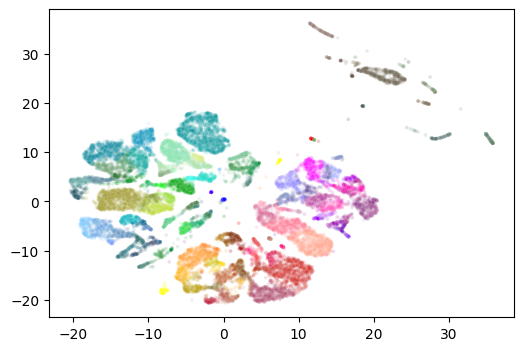

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.8017127025438671, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.8232383990074135, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.3359527607533653, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.47685668709596174, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.5938292334816556, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 1min 56s (started: 2022-12-25 14:50:17 -08:00)


In [5]:
pl.standard_eval(
    method=[
        pl.embedder(
            "smmds",
            params=dict(n_epochs=5000, n_samples=3, learning_rate=1.0),
        ),
        pl.embedder("rescale", params=dict(max_coord=40)),
        pl.embedder("tsne", params=dict(learning_rate=10)),
    ],
    dataset="tasic2018-pca50",
)

Compared to the output of the hybrid version of SQuadMDS (top right of Figure 6 of the paper), this shows a tolerable resemblance.

## Using SMMDS outside of drnb

If you are capable of installing drnb but don't want to deal with all this pipeline nonsense:

[14:52:14] INFO     Initializing via (unscaled) PCA                                                     ]8;id=874050;file:///home/james/dev/drnb/src/drnb/yinit.py\yinit.py]8;;\:]8;id=360389;file:///home/james/dev/drnb/src/drnb/yinit.py#42\42]8;;\

<AxesSubplot: >

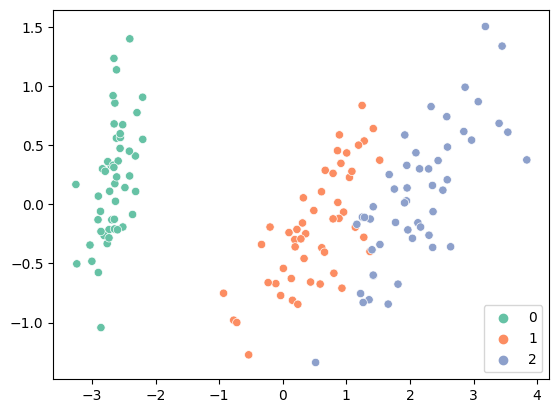

time: 3.81 s (started: 2022-12-25 14:52:14 -08:00)


In [6]:
import seaborn as sns
from sklearn.datasets import load_iris

from drnb.embed.smmds import smmds

iris = load_iris()
coords = smmds(iris.data, n_epochs=5000)

sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=iris.target, palette="Set2")

To liberate SMMDS further, the algorithm is in `drnb.embed.smmds`, and the optimizers in `drnb.optim`. There is some initialization, random number generation and distance calculation code dependent on [pynndescent](https://github.com/lmcinnes/pynndescent) and [umap](https://github.com/lmcinnes/umap) but these can all be easily replaced if you only want Euclidean distances and PCA-based initialization.